In [ ]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = "" # apparently spaCy and pandas don't play nice
from tca import ToxicCommentsAnalysis, pkl_load, pkl_dump
import pandas as pd

tca = ToxicCommentsAnalysis('train.csv', 'data')

Toxic comments object initialized


In [ ]:
tca.scrub_comments()

In [ ]:
tca.add_upper_lower_punc(verbose=True)
tca.ck_spelling_toxicity(verbose=True)

In [ ]:
tca.vectorize_text(mode='prop', data='all')
tca.create_token_correlations(verbose=True)

(<Figure size 864x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20458e626a0>)

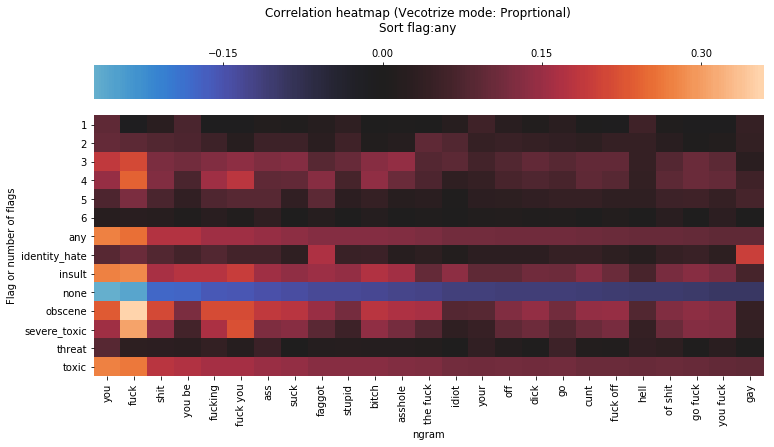

In [4]:
tca.make_corr_heatmap(figsize=(12,6), sortflag='any', ascending=False)

In [6]:
tca.create_sample(10000)
tca.vectorize_text(data='sample', mode='prop')
tca.manifold(mode='tsne')
tca.prep_manifold_plotting()

c:\python36\lib\site-packages\scipy\sparse\base.py:580: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


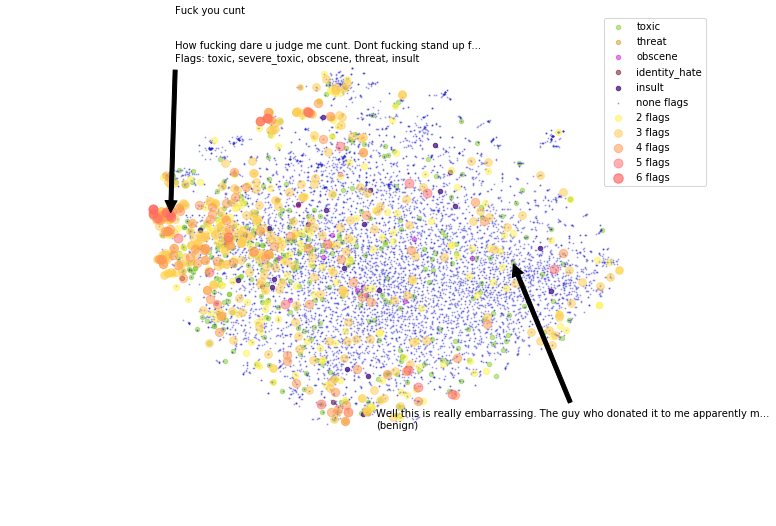

In [5]:
tca.plot_manifold()

In [2]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import spacy
nlp = spacy.load('en')

def make_tagged_documents(df, df_sample):
    docs = []
    doclabels = []
    
    sample_ids = df_sample['id'].tolist()
    ids = df[~df.id.isin(sample_ids)]['id'].tolist()
    for comment_id in ids:
        df_tmp = df[df.id == comment_id]
        doc = df_tmp['comment_scrubbed'].values[0]
        doclabel = []
        doc_tokenized = []
        doc_nlp = nlp(doc)
        for token in doc_nlp:
            tk = token.text.lower().strip()
            if len(tk) > 0:
                doc_tokenized.append(token.text.lower().strip())
        docs.append(doc_tokenized)
        
        doclabel.append(comment_id)
        for flag in tca.toxic_flags_:
            if df_tmp[flag].values[0] == 1:
                doclabel.append(flag)
        if len(doclabel) == 0:
            doclabel.append('none')
        doclabels.append(doclabel)
        
    tagged_docs = [TaggedDocument(doc, doclabels[i]) for i, doc in enumerate(docs)]
    return tagged_docs

c:\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#docs, ids, labels = get_comments_and_labels(tca.df)
tagged_docs= make_tagged_documents(tca.df, tca.df_sample)

In [4]:
model = Doc2Vec(tagged_docs, vector_size=200, window=3, min_count=10, workers=4)

#model.train(tagged_docs, epochs=30, total_examples=model.corpus_count)

0.025

In [5]:
def spacy_tokenize(docs):
    import spacy
    nlp = spacy.load('en')
    

    docs_tokenized = []
    for doc in docs:
        doc_nlp = nlp(doc)
        doc_tokenized = []
        for token in doc_nlp:
            tk = token.text.lower().strip()
            if len(tk) > 0:
                doc_tokenized.append(token.text.lower().strip())

        docs_tokenized.append(doc_tokenized)

    return docs_tokenized

sampledocs = spacy_tokenize(tca.df_sample['comment_scrubbed'].tolist())

docvecs = []

In [6]:
for sampledoc in sampledocs:
    docvecs.append(model.infer_vector(doc_words=sampledoc))

In [7]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
dv = np.asarray(docvecs)
mf = TSNE()

#dv_pca = pca.fit_transform(dv)
dv_tsne = mf.fit_transform(dv)

tca.df_sample['mf_d2v_X0'] = dv_tsne[:,0]
tca.df_sample['mf_d2v_X1'] = dv_tsne[:,1]

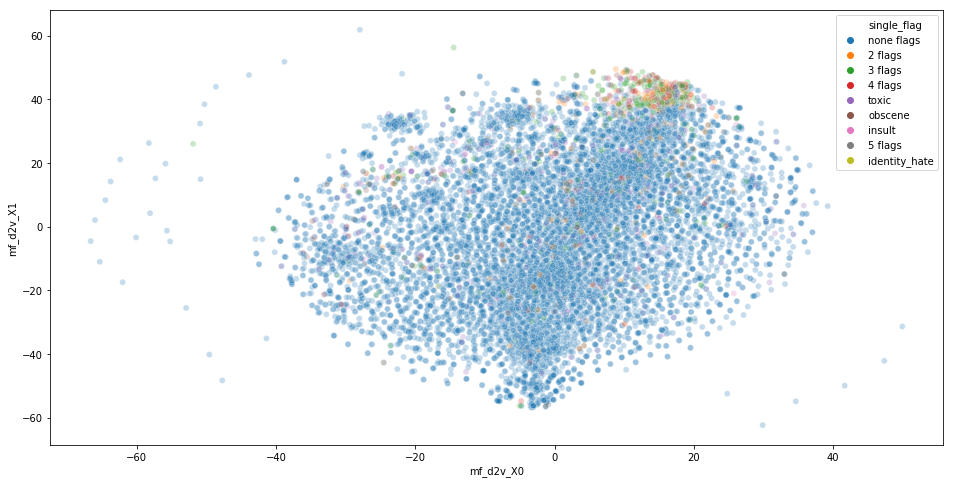

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots (nrows=1, ncols=1, figsize=(16,8))
sns.scatterplot(data=tca.df_sample, x='mf_d2v_X0', y='mf_d2v_X1', hue='single_flag', alpha=.25, ax=ax)